In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install geemap
!pip install geopandas
!pip install rasterio
!pip install rasterio geopandas scikit-learn matplotlib seaborn


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 73.8 MB/s eta 0:00:00


# Step 1: Upload the multiband GeoTIFF image and training data GeoPackage to Google Colab (or mount your Google Drive folder)

In [6]:
import geopandas as gpd
import ee
import geemap
import os
# Import necessary libraries
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Step 2: Read the multiband tiff image

In [3]:
import rasterio
import numpy as np

# Load the 2017 image
with rasterio.open('/content/drive/MyDrive/EarthEngine/LakeU_Sentinel2_2017.tif') as src_2017:
    img_2017 = src_2017.read()
    img_2017 = img_2017.astype('float32') / 10000
    img_2017 = np.nan_to_num(img_2017, nan=0.0)

# Load the 2024 image
print("2017 image loaded.")
#with rasterio.open('/content/drive/MyDrive/EarthEngine/Sentinel2_2024.tif') as src_2024:
with rasterio.open('/content/drive/MyDrive/EarthEngine/Sentinel2_2024_matched.tif') as src_2024:
    img_2024 = src_2024.read()
    img_2024 = img_2024.astype('float32') / 10000
    img_2024 = np.nan_to_num(img_2024, nan=0.0)
print("2024 image loaded.")

print(img_2017.shape)
print(img_2024.shape)



2017 image loaded.
2024 image loaded.
(4, 5695, 4771)
(4, 5695, 4771)


# Step 3: Read the vector training areas from GeoPackage

In [2]:
import rasterio
import numpy as np

def load_and_normalize_image(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()
        img = np.nan_to_num(img, nan=0.0)  # Replace NaN values with 0
        img = img.astype('float32')

        # Min-max normalization for each band
        for i in range(img.shape[0]):
            band_min = img[i].min()
            band_max = img[i].max()
            img[i] = (img[i] - band_min) / (band_max - band_min)

        transform = src.transform
        crs = src.crs
    return img, transform, crs

# Load and normalize the 2017 image
img_2017, transform_2017, crs_2017 = load_and_normalize_image('/content/drive/MyDrive/EarthEngine/LakeU_Sentinel2_2017.tif')
print(f"2017 Image: min={np.min(img_2017)}, max={np.max(img_2017)}, mean={np.mean(img_2017)}")

# Load and normalize the 2024 image
img_2024, transform_2024, crs_2024 = load_and_normalize_image('/content/drive/MyDrive/EarthEngine/Sentinel2_2024_matched.tif')
print(f"2024 Image: min={np.min(img_2024)}, max={np.max(img_2024)}, mean={np.mean(img_2024)}")


2017 Image: min=0.0, max=1.0, mean=0.0915708988904953
2024 Image: min=0.0, max=1.0, mean=0.09157904237508774


# Step 4: Extract pixel values from the image (X) corresponding to training data (y)

In [7]:
# Path to the labeled shapefile
geopackage_path = '/content/drive/MyDrive/EarthEngine/ROI.gpkg'

# Read the labeled GeoPackage file
labeled_gdf = gpd.read_file(geopackage_path)

# Ensure the GeoDataFrame is in the correct projection (WGS84)
labeled_gdf = labeled_gdf.to_crs(epsg=4326)

# Filter out rows with None or empty geometries
labeled_gdf = labeled_gdf[~labeled_gdf.is_empty]

# Display the first few rows to check the data
print(labeled_gdf.head())

   id                                           geometry
0   1  MULTIPOLYGON (((44.86063 38.15000, 44.90660 38...
1   1  MULTIPOLYGON (((45.33469 38.40408, 45.37621 38...
2   1  MULTIPOLYGON (((45.09741 38.30027, 45.14190 38...
3   1  MULTIPOLYGON (((44.92390 38.01949, 44.97087 38...
4   1  MULTIPOLYGON (((45.05737 38.08079, 45.10433 38...


# Step 5: Split data into training and testing sets

In [8]:
import rasterio.features
import geopandas as gpd

# Function to ensure geometries are valid and have the correct CRS
def preprocess_geometries(labeled_gdf, target_crs):
    labeled_gdf = labeled_gdf[labeled_gdf['geometry'].notnull()]
    labeled_gdf = labeled_gdf[labeled_gdf.is_valid]
    if labeled_gdf.crs != target_crs:
        labeled_gdf = labeled_gdf.to_crs(target_crs)
    return labeled_gdf

# Function to extract training data
def extract_training_data(image, labeled_gdf, transform, num_samples_per_class=500):
    X = []
    y = []
    for index, row in labeled_gdf.iterrows():
        geom = [row['geometry']]  # Geometry must be a sequence
        label = row['id']  # Adjust the column name to reflect your label column

        # Create a mask for the polygon
        mask = rasterio.features.geometry_mask(geom, transform=transform, invert=True, out_shape=(image.shape[1], image.shape[2]))

        # Extract pixel values within the polygon
        pixels = np.column_stack([np.ma.masked_array(image[band], mask=~mask).compressed() for band in range(image.shape[0])])

        # Randomly sample a subset of pixels if there are too many
        #if pixels.shape[0] > num_samples_per_class:
        #    indices = np.random.choice(pixels.shape[0], num_samples_per_class, replace=False)
        #    pixels = pixels[indices]

        X.extend(pixels)
        y.extend([label] * pixels.shape[0])

    return np.array(X), np.array(y)

# Preprocess geometries
#target_crs = rasterio.open('/content/drive/My Drive/EarthEngine/Sentinel2_2024.tif').crs
#labeled_gdf = preprocess_geometries(labeled_gdf, target_crs)

# Extract training data from the 2017 image
X_train, y_train = extract_training_data(img_2017, labeled_gdf, transform_2017)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Training data shape: (600338, 4)
Training labels shape: (600338,)


# Step 6: Train a MLP classifier

Iteration 1, loss = 0.06832748
Iteration 2, loss = 0.01508912
Iteration 3, loss = 0.01349419
Iteration 4, loss = 0.01204410
Iteration 5, loss = 0.01050000
Iteration 6, loss = 0.00927505
Iteration 7, loss = 0.00821125
Iteration 8, loss = 0.00733076
Iteration 9, loss = 0.00680855
Iteration 10, loss = 0.00642523
Iteration 11, loss = 0.00625401
Iteration 12, loss = 0.00619312
Iteration 13, loss = 0.00609737
Iteration 14, loss = 0.00593809
Iteration 15, loss = 0.00601076
Iteration 16, loss = 0.00585652
Iteration 17, loss = 0.00578432
Iteration 18, loss = 0.00580354
Iteration 19, loss = 0.00576789
Iteration 20, loss = 0.00569481
Iteration 21, loss = 0.00557196
Iteration 22, loss = 0.00557131
Iteration 23, loss = 0.00550140
Iteration 24, loss = 0.00552094
Iteration 25, loss = 0.00543956
Iteration 26, loss = 0.00552447
Iteration 27, loss = 0.00546867
Iteration 28, loss = 0.00556024
Iteration 29, loss = 0.00549897
Iteration 30, loss = 0.00542737
Iteration 31, loss = 0.00536330
Iteration 32, los

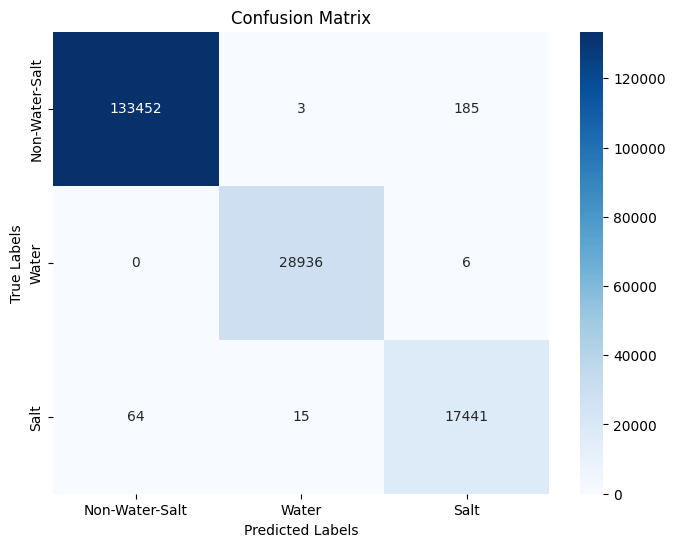

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, alpha=1e-4,
                    solver='adam', verbose=5, tol=1e-4, random_state=1,
                    learning_rate_init=.001)

# Train the model
mlp.fit(X_train_split, y_train_split)

# Evaluate the model
y_pred_split = mlp.predict(X_test_split)
print("Classification report for test data:")
print(classification_report(y_test_split, y_pred_split))


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_split, y_pred_split)
custom_labels = ['Non-Water-Salt', 'Water', 'Salt'] # {1:'not_dune', 2:'dune'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




# Step 7: Evaluate the classifier

In [3]:
# Reshape the 2017 image data to (n_samples, n_features)
n_samples = img_2017.shape[1] * img_2017.shape[2]
X_2017 = img_2017.reshape((img_2017.shape[0], n_samples)).T

# Predict the land cover and land use for 2017
y_pred_2017 = mlp.predict(X_2017)

# Reshape the predictions back to the original image shape
y_pred_2017_img = y_pred_2017.reshape((img_2017.shape[1], img_2017.shape[2]))

# Save the classification result as a new GeoTIFF
#with rasterio.open('/content/drive/My Drive/EarthEngine/RF_2024_LCLU.tif', 'w', driver='GTiff',
#                   height=img_2017.shape[1], width=img_2017.shape[2], count=1, dtype=y_pred_2017_img.dtype,
#                   crs=src_2024.crs, transform=src_2024.transform) as dst:
#    dst.write(y_pred_2017_img, 1)

NameError: name 'mlp' is not defined

In [1]:
# Reshape the 2024 image data to (n_samples, n_features)
n_samples = img_2024.shape[1] * img_2024.shape[2]
X_2024 = img_2024.reshape((img_2024.shape[0], n_samples)).T
#X_2024 = np.nan_to_num(X_2024, nan=0.0)

# Predict the land cover and land use for 2024
y_pred_2024 = mlp.predict(X_2024)

# Reshape the predictions back to the original image shape
y_pred_2024_img = y_pred_2024.reshape((img_2024.shape[1], img_2024.shape[2]))

# Save the classification result as a new GeoTIFF
#with rasterio.open('/content/drive/My Drive/EarthEngine/RF_2024_LCLU.tif', 'w', driver='GTiff',
#                   height=img_2024.shape[1], width=img_2024.shape[2], count=1, dtype=y_pred_2024_img.dtype,
#                   crs=src_2024.crs, transform=src_2024.transform) as dst:
#    dst.write(y_pred_2024_img, 1)


NameError: name 'img_2024' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Visualize the classification result for 2017
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2017")
plt.imshow(y_pred_2017_img, cmap='tab10')
plt.colorbar()
plt.show()

# Visualize the classification result for 2024
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2024")
plt.imshow(y_pred_2024_img, cmap='tab10')
plt.colorbar()
plt.show()